In [1]:
import numpy as np
import pandas as pd
import scipy, scipy.spatial
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import speechpy
from pydub import AudioSegment
from matplotlib.patches import ConnectionPatch
%matplotlib inline

import io
from urllib.request import urlopen

In [5]:
def sound_diff(path, ref, target, sr):
        
    def getMFCC(signal, n_mfcc, sr, hop_length, n_fft):
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
        mfccs = mfccs[1:,]
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
        return comprehensive_mfccs
        
    def amplitude_envelope(signal, n_fft, hop_length):
        return np.array([max(signal[i:i+n_fft]) for i in range(0, len(signal), hop_length)])
    
    def pad(ae, target_len):
        return np.pad(ae, (0, target_len-ae.size))

    def getMFCCNorm(mfcc):
        norm = speechpy.processing.cmvn(mfcc.T, variance_normalization=True)
        return norm.T

    def DTW(ref_mfcc, comp_mfcc):
        D, wp = librosa.sequence.dtw(X=ref_mfcc, Y=comp_mfcc, metric='euclidean')
        wp_s = np.asarray(wp) * hop_length / sr
        return D, wp, wp_s
    
    def plotDTW(D, wp_s):
        fig = plt.figure(figsize=(13, 10))
        ax = fig.add_subplot(111)
        librosa.display.specshow(D, x_axis='time', y_axis='time',
                                cmap='gray_r', hop_length=hop_length)
        ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
        plt.rcParams['axes.grid']=False
        plt.colorbar()
        plt.title('Warping Path on Acc. Cost Matrix $D$')
        plt.show()
    
    def getDiff(ref_mfcc, comp_mfcc, wp, sr, hop_length, n_fft):
        size = max(ref_mfcc.shape[1], comp_mfcc.shape[1])
        x = np.linspace(0, size-1, size)
        x_time = librosa.frames_to_time(x, sr=sr, hop_length=hop_length, n_fft = n_fft)
        re_wp = wp[::-1]
        y = []
        passed = 0
        for ref_fr, comp_fr in re_wp:
            if len(y) >= size:
                passed += 1
                continue
            a,b = scipy.stats.pearsonr(ref_mfcc[:,ref_fr], comp_mfcc[:,comp_fr])
            a = abs(a)
            y.append(round(1-a,4))
        print("passed y: ", passed)
        return x_time, y, re_wp
    
    def timeAlign(ref_trim, comp_trim, sr):
        flag = 1
        # where comparison signal is longer than the reference
        if comp_trim.shape[0] > ref_trim.shape[0]:
            c = scipy.signal.correlate(comp_trim, ref_trim, mode="valid", method="fft")
            peak = np.argmax(c)
            if int(round(peak,0)) + ref_trim.shape[0] < comp_trim.shape[0]:
                pad_num = int(round(peak,0))
            else:
                pad_num = comp_trim.shape[0] - ref_trim.shape[0]
            ref_trim = np.pad(ref_trim, (pad_num,0), 'linear_ramp', end_values=(0,0))
            flag = 0
        
        elif comp_trim.shape[0] < ref_trim.shape[0]:
            c = scipy.signal.correlate(ref_trim, comp_trim, mode="valid", method="fft")
            peak = np.argmax(c)
            if int(round(peak,0)) + comp_trim.shape[0] < ref_trim.shape[0]:
                pad_num = int(round(peak,0))
            else:
                pad_num = ref_trim.shape[0] - comp_trim.shape[0]
            comp_trim = np.pad(comp_trim, (pad_num,0), 'linear_ramp', end_values=(0,0))
            flag = 1
        time_lag = pad_num/sr
        return ref_trim, comp_trim, time_lag, flag
    
    def plotAlign(ref, comp, x, y, ref_ae, comp_ae, time_lag, flag):
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(13, 15))
        
        # Plot x_2
        librosa.display.waveshow(comp, sr=sr, ax=ax2)
        ax2.set(title='comparison waveplot')
        ax2.grid(True, axis='both')

        # Plot x_1
        librosa.display.waveshow(ref, sr=sr, ax=ax1)
        ax1.set(title='reference waveplot')
        ax1.label_outer()
        ax1.grid(True, axis='both')
        
        n_arrows = 20
        if flag == 0:
            for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
                tp1 += time_lag
                con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                                    axesA=ax1, axesB=ax2,
                                    coordsA='data', coordsB='data',
                                    color='r', linestyle='--',
                                    alpha=0.5)
                ax2.add_artist(con)
        
        else:
            for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
                tp2 += time_lag
                con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                                    axesA=ax1, axesB=ax2,
                                    coordsA='data', coordsB='data',
                                    color='r', linestyle='--',
                                    alpha=0.5)
                ax2.add_artist(con)

        if comp_ae.size < x.size:
            comp_ae = pad(comp_ae, x.size)
        if ref_ae.size < x.size:
            ref_ae = pad(ref_ae, x.size)
            
        ax3.set(title='ref v comparison')
        ax3.grid(True, axis='both')
        ax3.plot(x,y, label="MFCC_Diff", color="r", linestyle='--')
        ax3.plot(x,ref_ae, label="ref", color = 'darkblue')
        ax3.plot(x,comp_ae, label="comp", color = 'skyblue')
        ax3.set_xlabel("Time")
        ax3.set_ylim(ymin=0, ymax=1)
        ax3.legend()

    plt.style.use('seaborn-muted')

    y_ref, sr = librosa.load(path+ref, mono=True, sr=sr)
    y_comp, _ = librosa.load(path+target, mono=True, sr=sr)

    hop_length = int(round(0.01 * sr,0))
    n_fft = int(round(0.025 * sr,0))

    y_ref = librosa.effects.preemphasis(y_ref)
    y_comp = librosa.effects.preemphasis(y_comp)

    y_ref_trim, _ = librosa.effects.trim(y_ref, top_db = 25)
    y_comp_trim, _ = librosa.effects.trim(y_comp, top_db = 25)

    ref_mfcc = getMFCC(y_ref_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
    comp_mfcc = getMFCC(y_comp_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)

    ref_mfcc_norm = getMFCCNorm(ref_mfcc)
    comp_mfcc_norm = getMFCCNorm(comp_mfcc)

    D, wp, wp_s = DTW(ref_mfcc_norm, comp_mfcc_norm)

    plotDTW(D, wp_s)

    x_time, y, re_wp = getDiff(ref_mfcc_norm, comp_mfcc_norm, wp, sr, hop_length, n_fft)
    y_ref_trim, y_comp_trim, time_lag, flag = timeAlign(y_ref_trim, y_comp_trim, sr)
    ref_ae = amplitude_envelope(y_ref_trim, n_fft, hop_length)
    comp_ae = amplitude_envelope(y_comp_trim, n_fft, hop_length)
    plotAlign(y_ref_trim, y_comp_trim, x_time, y, ref_ae, comp_ae, time_lag, flag)

In [6]:
path1 = '../english_recordings/test_wav/'
path2 = '../english_recordings/test/'
ref = 'english2_ts.mp3'
comp = 'korean2_ts.mp3'
sr = 22050

/Users/hsada17/opt/anaconda3/envs/ds_study/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/hsada17/opt/anaconda3/envs/ds_study/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


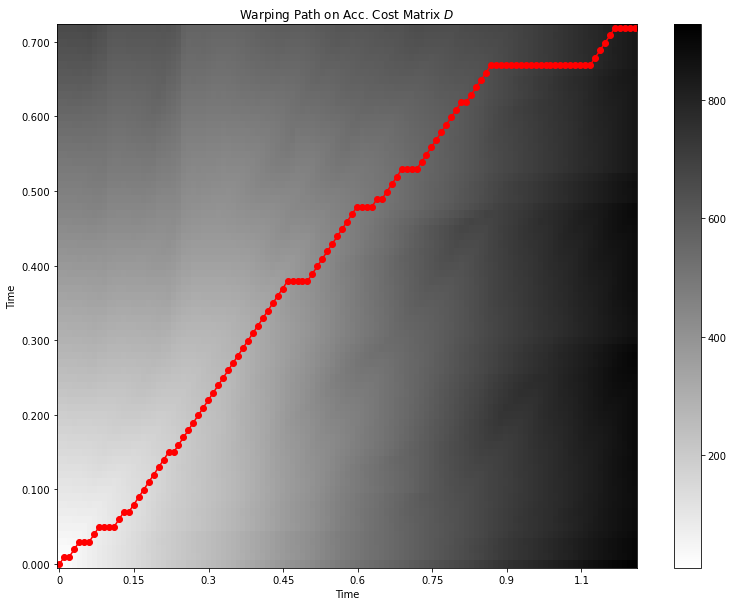

passed y:  0


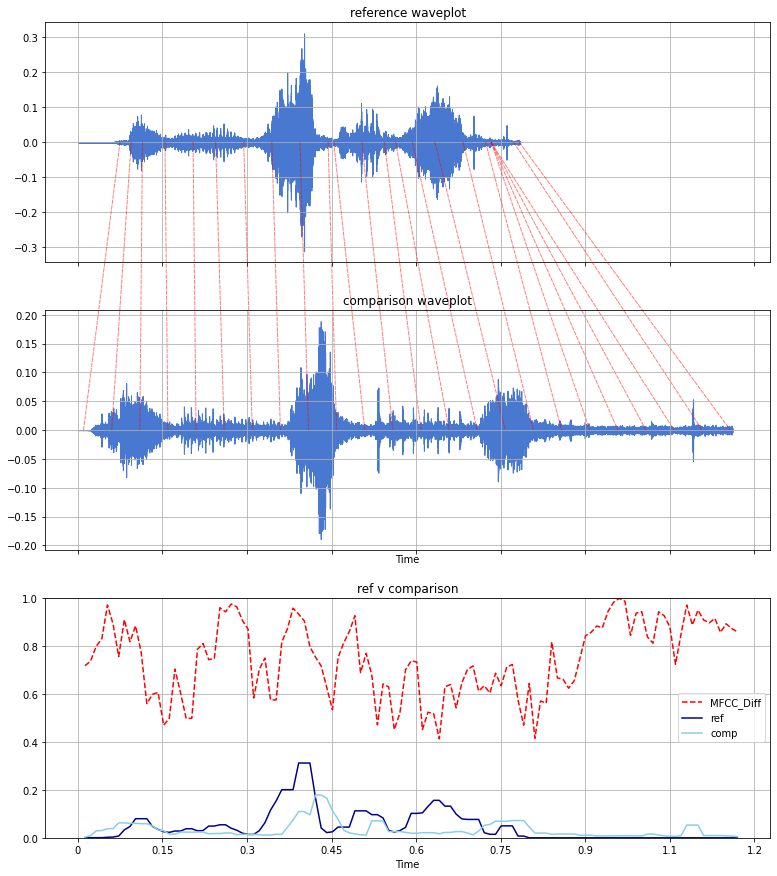

In [7]:
sound_diff(path2, ref, comp, sr)